Same as final-notebook except this one doesn't keep all objects in the same matrix

In [9]:
# Reading the data

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pathlib
from copy import copy
from matplotlib import cm, colors
import cv2

emptyRatio = 47
objectwidth = 83
objectheight = 122
xspacing = 133
yspacing = 270
xstart = 293
ystart = 268
xend = 1730
yend = 1770
powderthickness = 80
endlayer = 187
objectsplit = 13
layersPerObject = endlayer // objectsplit
# Approximate one third test data
testEnd = endlayer - layersPerObject * (objectsplit // 3)

paths = pathlib.Path('./OT data 80 um/int').glob('*.tif')
paths_sorted = [x for x in paths]
paths_sorted.sort()
block = np.array([np.array(plt.imread(path)) for path in paths_sorted])
integrals = block[0:endlayer]

del paths_sorted

In [12]:
objectinfo = pd.read_csv('Parameters.csv', names=["Object", "P", "S", "H", "Porosity", "Label"])
objectinfo.insert(1, "VED", objectinfo.P * 1000/(objectinfo.S * objectinfo.H * powderthickness))
objectCoordinates = [[x, x+objectwidth, y, y+objectheight] for y in reversed(range(
    ystart, yend, objectheight + yspacing)) for x in range(xstart, xend, xspacing + objectwidth)]
coorddf = pd.DataFrame(objectCoordinates, columns=['xstart', 'xend', 'ystart', 'yend'])
objectinfo = coorddf.join(objectinfo)
zs = [objectinfo.copy().assign(zstart=z, zend=z+layersPerObject) for z in range(0, testEnd-layersPerObject, layersPerObject)]
testzs = [objectinfo.copy().assign(zstart=z, zend=z+layersPerObject) for z in range(testEnd, endlayer-layersPerObject+1, layersPerObject)]

objectinfo = pd.concat(zs, ignore_index=True)
testobjectinfo = pd.concat(testzs, ignore_index=True)

del zs
del testzs
del coorddf
del objectCoordinates

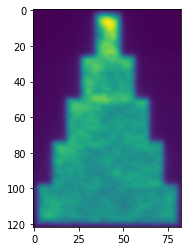

: 

In [18]:
objects = np.full((len(objectinfo), layersPerObject, objectheight, objectwidth), np.nan)
testobjects = np.full((len(testobjectinfo), layersPerObject, objectheight, objectwidth), np.nan)

objects.drop(objects[objects.Label == 'KH'].index, inplace=True)
objects.replace('GOOD', 0, inplace=True)
objects.replace('LOF', 1, inplace=True)
testobjects.drop(objects[objects.Label == 'KH'].index, inplace=True)
testobjects.replace('GOOD', 0, inplace=True)
testobjects.replace('LOF', 1, inplace=True)

# Double check maybe that iterrows gives the correct order?
for index, object in objectinfo.iterrows():
    objects[index] = integrals[object.zstart:object.zend, object.ystart:object.yend, object.xstart:object.xend]
for index, object in testobjectinfo.iterrows():
    testobjects[index] = integrals[object.zstart:object.zend, object.ystart:object.yend, object.xstart:object.xend]

In [19]:
from sklearn import neighbors, metrics
from sklearn.model_selection import cross_val_score, LeaveOneOut
from sklearn import preprocessing
from datetime import datetime

def preprocess(object, type, sharpening):
    sharpeningKernel = np.array([   [-1, -1,  -1],
                                    [-1,  9,  -1],
                                    [ -1, -1,  -1]
    ]) if sharpening == 'diagonal' else np.array([  [0, -1,  0],
                                                    [-1, 5, -1],
                                                    [0, -1,  0]])
    sharpened = np.array([cv2.filter2D(src=image, ddepth=-1, kernel=sharpeningKernel) for image in object])
# Sharpening is done
    if type == 'scatter':
        xs = np.array(sharpened, copy=True, dtype=np.float32)
        sum = np.sum(sharpened, axis=0)
        limit = np.percentile(sum, emptyRatio)
        filter = sum >= limit
        (endLayer, _, _) = xs.shape
        filter = np.repeat([filter], endLayer, 0)
        xs[~filter] = np.nan
        return xs
    elif type == 'moran':
        xs = np.array(sharpened, copy=True, dtype=np.float32)
        sum = np.sum(xs, axis=0)
        limit = np.percentile(sum, emptyRatio)
        filter = sum >= limit
        (endLayer, _, _) = xs.shape
        filter = np.repeat([filter], endLayer, 0)
        avg = np.mean(xs, where=filter)
        stddev = np.std(xs, where=filter)
        xs = (xs - avg) / avg
        xs[~filter] = np.nan
        return xs
    elif type == 'spatstat':
        # Implement later
        print("nyi")

def makeNeighbourhood(sharpened, neighbourhood, windowSize):
    neighbourkernel = np.array(
        [[1, 1, 1],
         [1, 1, 1],
         [1, 1, 1]]
    )/9 if neighbourhood == 'grid' else np.array(
        [[1, 2,  1],
        [2, 4, 2],
        [1, 2,  1]])/16
    flatNeighbourhood = np.array([cv2.filter2D(src=layer, ddepth=-1, kernel=neighbourkernel) for layer in sharpened])
    (endLayer, _, _) = flatNeighbourhood.shape
    neighbourhoodValues = np.array([
        np.sum(flatNeighbourhood[layerIndex-windowSize:layerIndex], axis=0)/windowSize
        for layerIndex in range(windowSize, endLayer+1)
    ])
    return neighbourhoodValues

def calculateoutliers(object, type, sharpening, neighbourhood, windowSize):
    offset = windowSize // 2
    endoffset = windowSize - offset - 1
    init = False

    if type == 'spatstat':
        print("nyi")
    else:
        outliervalues = np.full(np.shape(neighbourhood), 0.0)
        # Is the axis right for moran/scatter?
        xs = object[offset:-endoffset]
        ys = neighbourhood[0:-windowSize+1]
        filter = np.logical_and(np.isfinite(xs), np.isfinite(ys))
        line = np.polyfit(ys[filter].flatten(), xs[filter].flatten(), 1)
        p = np.poly1d(line)
        return xs - p(ys)

def encode(outlierobjects, type, buckets, histnormalise, minval=0, maxval=0):
    # Note: remove KF objects at some point...
    init = False

    numberOfObjects, _, _, _ = outlierobjects.shape
    X = np.full((numberOfObjects, buckets), np.nan)
    if type == 'spatstat':
        print("nyi")
    else:
        minval = np.min(outlierobjects) if minval == 0 else minval
        maxval = np.max(outlierobjects) if maxval == 0 else maxval
        for index in range(0, numberOfObjects):
            xs = outlierobjects[index]
            # filter = np.isfinite(xs)
            hist, _ = np.histogram(xs[filter], bins=buckets, range=(minval, maxval))
            X[index] = np.array(hist)
        
        if (histnormalise == 'column'):
            X = preprocessing.normalize(X, axis=0)
        elif (histnormalise == 'row'):
            X = preprocessing.normalize(X, axis=1)
    return X, minval, maxval

def classify(Xtrain, Ytrain, Xtest, Ytest, n_neighbors):
    clf = neighbors.KNeighborsClassifier(n_neighbors, weights="distance")
    clf.fit(Xtrain, Ytrain)
    yfit = clf.predict(Xtest)
    return metrics.roc_auc_score(Ytest, yfit), metrics.precision_score(Ytest, yfit), metrics.recall_score(Ytest, yfit)

In [28]:
# Tweaking parameter settings
types = ['scatter', 'moran']
# types = ['scatter', 'moran', 'spatstat']
sharpening = ['direct', 'diagonal']
neighbourhoodSetting = ['grid', 'euclidean']
windowsizes = range(1, 8, 2)
buckets = range(30, 151, 30)
histnormalise = ('none', 'row')
#bucket-lower-limit?
k = range(2, 7)

In [31]:
# Now to tie it all together...
columns = ['type', 'sharpening', 'windowSize', 'neighbourhood', 'buckets', 'histnormalise', 'k-nearest', 'auc', 'precision', 'recall']
results = pd.DataFrame(columns=columns)
Ytrain = np.array(objects.loc[:,"Label"])
Ytest = np.array(testobjects.loc[:,"Label"])
for type in types:
    print(datetime.now(), "type: ", type)
    for sharpSetting in sharpening:
        print(datetime.now(), "sharpSetting: ", sharpSetting)
        for windowsize in windowsizes:
            print(datetime.now(), "windowsize: ", windowsize)
            preprocessed = preprocess(integrals, objectinfo, type, sharpSetting, windowsize)
            testpreprocessed = preprocess(testintegrals, testobjectinfo, type, sharpSetting, windowsize)
            for nSetting in neighbourhoodSetting:
                print(datetime.now(), "nSetting: ", nSetting)
                neighbourhood = makeNeighbourhood(preprocessed, nSetting, windowsize) 
                testneighbourhood = makeNeighbourhood(testpreprocessed, nSetting, windowsize)
                for histnorm in histnormalise:
                    for bucket in buckets:
                        print(datetime.now(), "histnorm: ", histnorm, "bucket: ", bucket)
                        Xtrain, Ytrain, minval, maxval = encode(preprocessed, objectinfo, neighbourhood, windowsize, type, bucket, histnorm)
                        Xtest, Ytest, _, _ = encode(testpreprocessed, testobjectinfo, testneighbourhood, windowsize, type, bucket, histnorm, minval=minval, maxval=maxval)
                        # Add encode for test as well
                        for n_neighbors in k:
                            score, precision, recall = classify(Xtrain, Ytrain, Xtest, Ytest, n_neighbors)
                            nextRow =  pd.DataFrame([[type, sharpSetting, windowsize, nSetting, bucket, histnorm, n_neighbors, score, precision, recall]], columns=columns)
                            results = pd.concat([results, nextRow])
                        results.to_csv('out2.csv', index=False, header=True)


2022-09-12 17:13:20.410441 type:  scatter
2022-09-12 17:13:20.410528 sharpSetting:  direct
2022-09-12 17:13:20.410536 windowsize:  1
2022-09-12 17:13:25.285992 nSetting:  grid
2022-09-12 17:13:33.230653 histnorm:  none bucket:  30
2022-09-12 17:13:42.289881 histnorm:  none bucket:  60
2022-09-12 17:13:50.208406 histnorm:  none bucket:  90
2022-09-12 17:13:57.887189 histnorm:  none bucket:  120
2022-09-12 17:14:05.630247 histnorm:  none bucket:  150
2022-09-12 17:14:13.355061 histnorm:  row bucket:  30
2022-09-12 17:14:21.164834 histnorm:  row bucket:  60
2022-09-12 17:14:28.987044 histnorm:  row bucket:  90
2022-09-12 17:14:37.335619 histnorm:  row bucket:  120
2022-09-12 17:14:45.505888 histnorm:  row bucket:  150
2022-09-12 17:14:53.870435 nSetting:  euclidean
2022-09-12 17:15:01.999241 histnorm:  none bucket:  30
2022-09-12 17:15:10.713550 histnorm:  none bucket:  60
2022-09-12 17:15:18.331377 histnorm:  none bucket:  90
2022-09-12 17:15:26.872010 histnorm:  none bucket:  120
2022-0

In [46]:
# Debug cell

type = "scatter"
sharpSetting = "direct"
windowSize = 3
preprocessed = preprocess(integrals, objectinfo, type, sharpSetting, windowsize)
# preprocessed = preprocess(integrals, objectinfo, type, sharpSetting, windowsize)
nSetting = "euclidean"
neighbourhood = makeNeighbourhood(preprocessed, nSetting, windowsize) 
# neighbourhood = makeNeighbourhood(preprocessed, nSetting, windowsize)
histnorm = "none"
bucket = 30
Xtrain, Ytrain = encode(preprocessed, objectinfo, neighbourhood, windowsize, type, bucket, histnorm)
# Add encode for test as well
# for n_neighbors in k:
#     score, precision, recall = classify(Xtrain, Ytrain, Xtest, Ytest, n_neighbors)
#     nextRow =  pd.DataFrame([[type, sharpSetting, windowsize, nSetting, bucket, histnorm, n_neighbors, score, precision, recall]], columns=columns)
# results.to_csv('out-2.csv', index=False, header=True)


In [17]:
type = "scatter"
sharpSetting = "direct"
windowSize = 1
# preprocessed = preprocess(integrals, objectinfo, type, sharpSetting, windowsize)
testpreprocessed = preprocess(testintegrals, testobjectinfo, type, sharpSetting, windowsize)
nSetting = "euclidean"
# neighbourhood = makeNeighbourhood(preprocessed, nSetting, windowsize) 
testneighbourhood = makeNeighbourhood(testpreprocessed, nSetting, windowsize)
histnorm = "none"
bucket = 30
print()
# Xtrain, Ytrain = encode(preprocessed, objectinfo, neighbourhood, windowsize, type, bucket, histnorm)
Xtest, Ytest = encode(testpreprocessed, testobjectinfo, testneighbourhood, windowsize, type, bucket, histnorm)
# Add encode for test as well
# for n_neighbors in k:
#     score, precision, recall = classify(Xtrain, Ytrain, Xtest, Ytest, n_neighbors)
#     nextRow =  pd.DataFrame([[type, sharpSetting, windowsize, nSetting, bucket, histnorm, n_neighbors, score, precision, recall]], columns=columns)
# results.to_csv('out-2.csv', index=False, header=True)



0 14 0 1
(14, 122, 83) (14, 122, 83) (141764,) (141764,)
0 14 0 1
(14, 122, 83) (14, 122, 83) (141764,) (141764,)
0 14 0 1
(14, 122, 83) (14, 122, 83) (141764,) (141764,)
0 14 0 1
(14, 122, 83) (14, 122, 83) (141764,) (141764,)
0 14 0 1
(14, 122, 83) (14, 122, 83) (141764,) (141764,)
0 14 0 1
(14, 122, 83) (14, 122, 83) (141764,) (141764,)
0 14 0 1
(14, 122, 83) (14, 122, 83) (141764,) (141764,)
0 14 0 1
(14, 122, 83) (14, 122, 83) (141764,) (141764,)
0 14 0 1
(14, 122, 83) (14, 122, 83) (141764,) (141764,)
0 14 0 1
(14, 122, 83) (14, 122, 83) (141764,) (141764,)
0 14 0 1
(14, 122, 83) (14, 122, 83) (141764,) (141764,)
0 14 0 1
(14, 122, 83) (14, 122, 83) (141764,) (141764,)
0 14 0 1
(14, 122, 83) (14, 122, 83) (141764,) (141764,)
0 14 0 1
(14, 122, 83) (14, 122, 83) (141764,) (141764,)
0 14 0 1
(14, 122, 83) (14, 122, 83) (141764,) (141764,)
0 14 0 1
(14, 122, 83) (14, 122, 83) (141764,) (141764,)
0 14 0 1
(14, 122, 83) (14, 122, 83) (141764,) (141764,)
0 14 0 1
(14, 122, 83) (14, 12

ValueError: too many values to unpack (expected 2)